After seetting up Lagrange problem, we have first order conditions as

\begin{equation*}
\begin{aligned}
&(c_t-l_t^{2})^{-\sigma} = \lambda_t\\
&(c_t-l_t^{2})^{-\sigma}2l_t = \lambda_t A_t k_t^{\theta} l_t^{-\theta} (1-\theta)\\
&\lambda_t = \lambda_{t+1}\beta[A_{t+1} \theta k_{t+1}^{\theta-1} l_{t+1}^{1-\theta} + (1-\delta)]
\end{aligned}
\end{equation*}

With the FOCs, the steady state capital and labor should satisfy

\begin{equation*}
\begin{aligned}
&A_t \theta (\frac{k^*}{l^*})^{\theta-1} + (1-\delta) = \frac{1}{\beta}\\
&2l^{*}= A_t(\frac{k^*}{l^*})^{\theta} (1-\theta)
\end{aligned}
\end{equation*}
Now let us define capital per capita in steady state as
$$k_l^{s} = \frac{k^{*}}{l^{*}}$$


From FOCs, substitue $\lambda_t$(using the marginal utility function) and $c_t$(using our budget constraint) , we know that: 
\begin{equation*}
\begin{aligned}
&f(k) = \beta[A \theta k_{t+1}^{\theta-1} l_{t+1}^{1-\theta} + (1-\delta)] - \frac{[A k_t^{\theta} l_t^{1-\theta} + k_t(1-\delta) - k_{t+1} - l_t^{2}]^{-\sigma}}{[A k_{t+1}^{\theta} l_{t+1}^{1-\theta}+ k_{t+1}(1-\delta)-k_{t+2}-l_{t+1}^{2}]^{-\sigma}} =0
\end{aligned}
\end{equation*}


\begin{aligned}
&l_t= [\frac{A k_t^{\theta} (1-\theta)}{2}]^{\frac{1}{(1+\theta)}}
\end{aligned}


# 1. Functions

In [73]:
class Parameters:
    def __init__(self, A, theta, delta, beta, sigma):
        '''
        A: TFP
        theta: capital share in output
        delta: depreciation rate
        beta: discount factor
        '''
        self.A = A 
        self.theta = theta
        self.delta = delta
        self.beta = beta
        self.sigma = sigma

In [94]:
#use the function to solve the optimal capital per capita k_l_s in ss
def ss_capital_per_capita(self):
    k_l_s = ((1 / self.beta + self.delta - 1) / (self.A * self.theta)) ** (1 / (self.theta - 1))
    return k_l_s

#knowing k_l_s, solve the optimal labor in ss
def ss_labor(self):
    k_l_s = ss_capital_per_capita(self)
    l_star = (1 - self.theta) / 2 * self.A * k_l_s ** self.theta
    return l_star

# calculate the optimal labor on the path using the current capital
def optimal_labor(self, k_0):
    l = (self.A * k_0**self.theta * (1 - self.theta) / 2) ** (1 / (1 + self.theta))
    return l

# once you have the optimal labor, calculate the optimal capital for the next period
def optimal_capital_next(self,k_0,c_0):
    l_temp = optimal_labor(self, k_0)
    return self.A * k_0**self.theta * l_temp**(1 - self.theta) + k_0 * (1 - self.delta) - c_0

# define c_{t+1}
def optimal_consumption_next(self, k_0, c_0):
    l_0 = optimal_labor(self, k_0)
    k_1 = optimal_capital_next(self,k_0,c_0)
    l_1 = optimal_labor(self,k_1)
    MU_0 = (c_0 - (l_0)**(2))**(-self.sigma)
    c_1 = (MU_0 / (self.beta*(self.A *self.theta*k_1**(self.theta-1) * (l_0)**(1-self.theta)+(1-self.delta))))**(-1/self.sigma) + (l_1)**(2)
    return c_1

# def the c_t and k_t path
def consumpation_path(self, k_0, c_0, t):
    c = np.zeros((t + 1, 1))  
    k = np.zeros((t + 1, 1))  
    k[0] = k_0
    c[0] = c_0
    for i in range(t):
        k[i + 1] = optimal_capital_next(self, k[i], c[i])  
        if k[i + 1] <= 0:
            k[i + 1] = 0
            break
        c[i + 1] = optimal_consumption_next(self, k[i], c[i])  
    result = np.hstack((k, c))
    return result


# define shooting path
def optimal_path(self,t,c_max,k_0, k_ss, c0_min=0.001):
    c0_max=c_max
    ite=0
    time = np.arange(0,t+1,1)
    while c0_max-c0_min>1e-16:
        c0=(c0_min+c0_max)/2
        simulation=consumpation_path(self,k_0, c0, t)
        if simulation[len(simulation)-1,0]<=k_ss:
            c0_max=c0
        else:
            c0_min=c0
        ite+=1
    return simulation



# Answers

In [75]:
params = Parameters(beta=0.99, sigma=2, theta=0.3, delta=0.07, A=0.6)

In [86]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
k_l_s = ss_capital_per_capita(params) # optimal capital per capita in ss
l_ss = ss_labor(params) # optimal labor in ss
k_ss = l_ss * k_l_s # optimal captial used in ss
print (k_l_s, l_ss, k_ss)

3.1793256781907986 0.29711173130702273 0.9446149566361424


In [96]:
k_0 = 0.75 * k_ss
k_2 = 0.85 * k_ss
c_max = 1
t = 150

In [97]:
k_sq = optimal_path(params, t, c_max, k_0, k_ss, c0_min=0.002)[:, 0]
k_sq

array([0.70846122, 0.71749535, 0.72621126, 0.73461775, 0.74272365,
       0.75053771, 0.75806863, 0.765325  , 0.77231533, 0.77904799,
       0.78553119, 0.79177304, 0.79778145, 0.80356419, 0.80912884,
       0.81448281, 0.81963335, 0.82458749, 0.8293521 , 0.83393387,
       0.83833928, 0.84257464, 0.84664608, 0.85055954, 0.85432077,
       0.85793537, 0.86140873, 0.86474609, 0.86795251, 0.87103289,
       0.87399196, 0.87683431, 0.87956434, 0.88218634, 0.8847044 ,
       0.88712252, 0.88944453, 0.89167413, 0.89381488, 0.89587023,
       0.89784349, 0.89973784, 0.90155638, 0.90330206, 0.90497773,
       0.90658614, 0.90812993, 0.90961166, 0.91103377, 0.91239861,
       0.91370845, 0.91496548, 0.91617179, 0.91732939, 0.91844023,
       0.91950617, 0.920529  , 0.92151045, 0.92245216, 0.92335574,
       0.92422271, 0.92505453, 0.92585263, 0.92661836, 0.92735302,
       0.92805786, 0.92873408, 0.92938284, 0.93000525, 0.93060238,
       0.93117524, 0.93172482, 0.93225206, 0.93275787, 0.93324

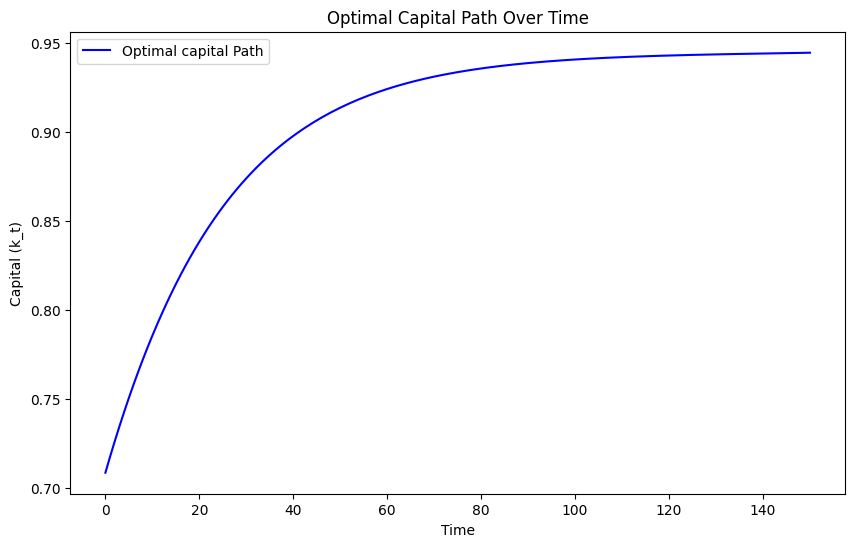

In [98]:
# plot the optimal capital
time = np.arange(0, t+1)
plt.figure(figsize=(10, 6))
plt.plot(time, k_sq, color='blue', label='Optimal capital Path')
plt.xlabel('Time')
plt.ylabel('Capital (k_t)')
plt.title('Optimal Capital Path Over Time')
plt.legend()
plt.show()